In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import annotations
from typing import Tuple, List

In [2]:
df = pd.read_excel('Datos/Aldebaran_pepsi.xlsx', sheet_name='Aldebaran_pepsi')
df.to_csv('Datos/Aldebaran_pepsi.csv', index=False)
iron = pd.read_excel('Datos/Moore.xlsx', sheet_name='Hoja1')
iron.to_csv('Datos/Moore.csv', index=False)

In [5]:

class InputDataError(ValueError):
    """Error para condiciones inválidas en los datos de entrada."""
    pass


def _check_inputs(x: np.ndarray, y: np.ndarray) -> None:
    """
    Verifica (sin modificar) que x e y sean arreglos 1D de igual longitud, sin NaNs,
    y que x sea estrictamente creciente. No reordena ni altera los datos.
    """
    if x is None or y is None:
        raise InputDataError("x e y no pueden ser None.")
    x = np.asarray(x)
    y = np.asarray(y)
    if x.ndim != 1 or y.ndim != 1:
        raise InputDataError("x e y deben ser 1D.")
    if x.size != y.size:
        raise InputDataError("x e y deben tener la misma longitud.")
    if np.any(~np.isfinite(x)) or np.any(~np.isfinite(y)):
        raise InputDataError("x e y no deben contener NaN o infinitos.")
    # x estrictamente creciente (sin ordenar)
    if not np.all(np.diff(x) > 0):
        raise InputDataError(
            "x debe ser estrictamente creciente (monótona) y no será reordenado.\n"
            "Ordena tus datos externamente si es necesario."
        )


def detect_discrete_minima_candidates(y: np.ndarray) -> np.ndarray:
    """
    Devuelve los índices i que cumplen la condición discreta de mínimo local:
        y[i-1] > y[i] < y[i+1]
    No aplica ningún filtrado ni umbral.
    """
    y = np.asarray(y)
    if y.size < 3:
        return np.array([], dtype=int)
    cond = (y[1:-1] < y[0:-2]) & (y[1:-1] < y[2:])
    # Ajustar offset de índices porque trabajamos con y[1:-1]
    return np.nonzero(cond)[0] + 1


def _fit_poly_and_refine_min(x_win, y_win, degree, x_center):
    coeffs = np.polyfit(x_win, y_win, deg=degree)
    p = np.poly1d(coeffs)
    dp = p.deriv(1)
    d2p = p.deriv(2)

    roots = np.roots(dp)
    roots = roots[np.isclose(roots.imag, 0, atol=1e-12)].real

    if len(roots) == 0:
        return np.nan, np.nan, False, False

    x_min, x_max = x_win.min(), x_win.max()
    roots = roots[(roots >= x_min) & (roots <= x_max)]
    if len(roots) == 0:
        return np.nan, np.nan, False, False

    # NUEVO: elegir la raíz más cercana al candidato discreto
    x_star = roots[np.argmin(np.abs(roots - x_center))]
    y_star = p(x_star)
    is_min = d2p(x_star) > 0

    return float(x_star), float(y_star), True, bool(is_min)



def find_local_minima_polyfit(
    x: np.ndarray,
    y: np.ndarray,
    window_pts: int = 15,
    degree: int = 4,
    min_points: int = None,
) -> pd.DataFrame:
    """
    Encuentra y refina mínimos locales usando un ajuste polinómico local.
    NO modifica x ni y.

    Parámetros
    ----------
    x, y : arrays 1D
        Datos originales. x debe ser estrictamente creciente; no se reordena.
    window_pts : int, default 15
        Número de puntos usados por ventana local (idealmente 10–20).
        Debe ser >= degree+1.
    degree : int, default 2
        Grado del polinomio local. degree=2 (cuadrático) suele ser suficiente.
    min_points : int, default None
        Mínimo de puntos exigidos para el ajuste (>= degree+1).
        Si None, se usa min_points = degree + 1.

    Retorna
    -------
    pandas.DataFrame con columnas:
        - idx_candidate : índice i detectado por la prueba discreta
        - x_refined     : posición refinada del mínimo (por el polinomio)
        - y_refined     : valor del polinomio en x_refined
        - degree        : grado del polinomio usado
        - window_start  : índice de inicio de la ventana usada (incluido)
        - window_end    : índice fin (excluido, estilo Python)
        - num_points    : puntos efectivos en el ajuste
        - root_in_window: True si la raíz de la derivada cayó dentro de la ventana
        - valid_minimum : True si la 2da derivada en x_refined fue > 0
    """
    _check_inputs(x, y)

    if window_pts < degree + 1:
        raise ValueError("window_pts debe ser al menos degree+1.")
    if min_points is None:
        min_points = degree + 1
    if min_points < degree + 1:
        raise ValueError("min_points debe ser >= degree+1.")

    n = len(x)
    half = window_pts // 2

    # 1) Detectar candidatos discretos sin alterar datos
    candidates = detect_discrete_minima_candidates(y)

    rows = []
    for i in candidates:
        # 2) Construir ventana [i - half, i + half] con manejo de bordes
        start = max(0, i - half)
        end = min(n, start + window_pts)
        # reajuste si estamos al final y la ventana quedó corta
        start = max(0, end - window_pts)

        x_win = x[start:end]
        y_win = y[start:end]

        if x_win.size < min_points:
            # No hay suficientes puntos para el grado requerido
            rows.append({
                "idx_candidate": int(i),
                "x_refined": np.nan,
                "y_refined": np.nan,
                "degree": degree,
                "window_start": int(start),
                "window_end": int(end),
                "num_points": int(x_win.size),
                "root_in_window": False,
                "valid_minimum": False,
            })
            continue

        # 3) Ajuste polinómico local y refinamiento del mínimo
        try:
            x_star, y_star, root_in_window, is_min = _fit_poly_and_refine_min(x_win, y_win, degree, x_center=x[i])

        except np.linalg.LinAlgError as e:
            # Problemas numéricos (por ejemplo, colinealidad severa)
            x_star, y_star, root_in_window, is_min = np.nan, np.nan, False, False

        rows.append({
            "idx_candidate": int(i),
            "x_refined": x_star,
            "y_refined": y_star,
            "degree": degree,
            "window_start": int(start),
            "window_end": int(end),
            "num_points": int(x_win.size),
            "root_in_window": bool(root_in_window),
            "valid_minimum": bool(is_min),
        })

    return pd.DataFrame(rows)

In [6]:
df = pd.read_csv('Datos/Aldebaran_pepsi.csv')

x = df.iloc[:,0]  # primera columna
y = df.iloc[:,1]  # segunda columna


df_min = find_local_minima_polyfit(x, y, window_pts=15, degree=2)

print(df_min.head())



   idx_candidate    x_refined  y_refined  degree  window_start  window_end  \
0             12  3950.153506   0.833435       2             5          20   
1             14  3950.150971   0.825138       2             7          22   
2             39  3950.356990   0.262190       2            32          47   
3             65          NaN        NaN       2            58          73   
4             88  3950.779558   0.964729       2            81          96   

   num_points  root_in_window  valid_minimum  
0          15            True          False  
1          15            True          False  
2          15            True           True  
3          15           False          False  
4          15            True           True  


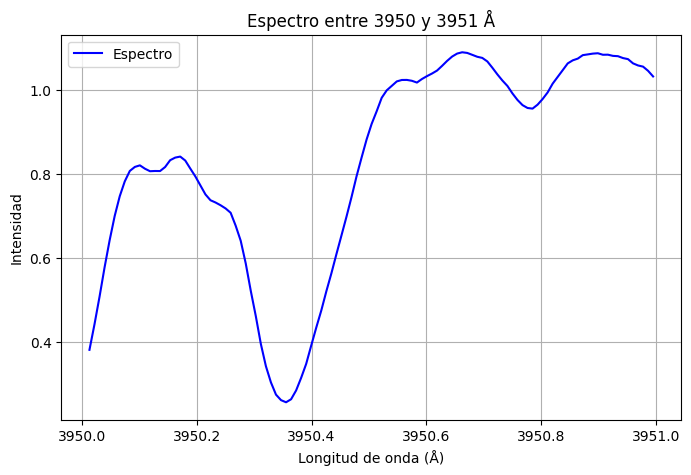

In [29]:
## Hacer un gráfico del espectro entre dos valores específicos de longitud de onda

x1 = 3950
x2 = 3951

mask = (x >= x1) & (x <= x2)
x_range = x[mask]
y_range = y[mask]

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x_range, y_range, label="Espectro", color="blue")

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Intensidad")
plt.title("Espectro entre 3950 y 3951 Å")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Tolerancia
tol = 0.05

# Crear lista para almacenar matches
matches = []

for i, theo in enumerate(iron.iloc[:,0]):  # recorremos las líneas teóricas
    # Filtrar mínimos observados que estén cerca de la línea teórica
    nearby = df_min[(df_min["x_refined"].notna()) & 
                    (abs(df_min["x_refined"] - theo) <= tol)]
    
    for _, obs in nearby.iterrows():
        matches.append({
            "lambda_theo": theo,                 # línea teórica (Fe I/II)
            "lambda_obs": obs["x_refined"],      # longitud observada en el espectro
            "y_obs": obs["y_refined"],           # intensidad observada
            "delta": obs["x_refined"] - theo     # diferencia entre observado y teórico
        })

# Pasar a dataframe
df_matches = pd.DataFrame(matches)

print(df_matches)


     lambda_theo   lambda_obs     y_obs     delta
0       4067.280  4067.284549  0.090959  0.004549
1       4079.843  4079.800973  0.102160 -0.042027
2       4085.013  4085.007630  0.148476 -0.005370
3       4087.101  4087.104188  0.182082  0.003188
4       4089.224  4089.207149  0.222946 -0.016851
..           ...          ...       ...       ...
549     9013.980  9013.976395  0.485857 -0.003605
550     9019.740  9019.736116  0.813363 -0.003884
551     9036.750  9036.743729  0.936508 -0.006271
552     9084.180  9084.191860  0.812710  0.011860
553     9103.635  9103.628309  0.741945 -0.006691

[554 rows x 4 columns]


In [ ]:
c = 299792.458

df_matches["velocity_kms"] = c * (df_matches["delta"]) / df_matches["lambda_theo"]

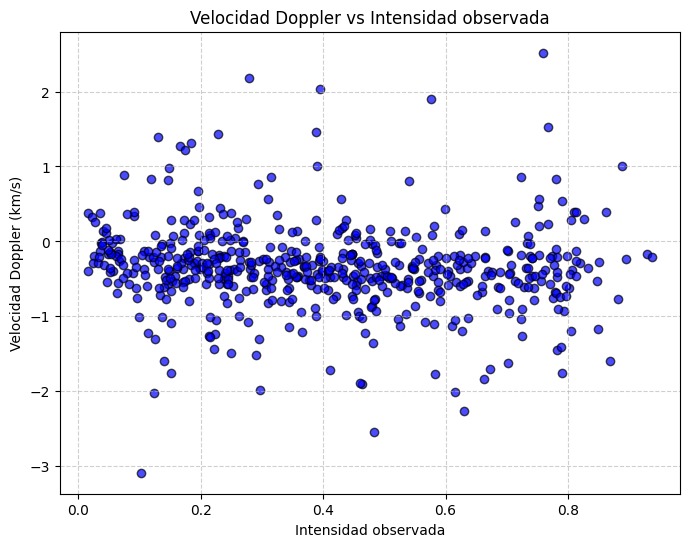

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df_matches['y_obs'], df_matches['velocity_kms'], color='blue', alpha=0.7, edgecolor='k')

# Etiquetas y título
plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (km/s)")
plt.title("Velocidad Doppler vs Intensidad observada")

# Grid y despliegue
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()